## Задача 1: сравнение предложений

Дан набор предложений, скопированных с Википедии. Каждое из них имеет "кошачью тему" в одном из трех смыслов:

  * кошки (животные)
  * UNIX-утилита cat для вывода содержимого файлов
  * версии операционной системы OS X, названные в честь семейства кошачьих
Ваша задача — найти два предложения, которые ближе всего по смыслу к расположенному в самой первой строке. В качестве меры близости по смыслу мы будем использовать косинусное расстояние.

#### Выполните следующие шаги:

1. Скачайте файл с предложениями (sentences.txt).
2. Каждая строка в файле соответствует одному предложению. Считайте их, приведите каждую к нижнему регистру с помощью строковой функции lower().
3. Произведите токенизацию, то есть разбиение текстов на слова. Для этого можно воспользоваться регулярным выражением, которое считает разделителем любой символ, не являющийся буквой: re.split('[^a-z]', t). Не забудьте удалить пустые слова после разделения.
4. Составьте список всех слов, встречающихся в предложениях. Сопоставьте каждому слову индекс от нуля до (d - 1), где d — число различных слов в предложениях. Для этого удобно воспользоваться структурой dict.
5. Создайте матрицу размера n x d, где n — число предложений. Заполните ее: элемент с индексом (i, j) в этой матрице должен быть равен количеству вхождений j-го слова в i-е предложение. У вас должна получиться матрица размера 22 * 254.
6. Найдите косинусное расстояние от предложения в самой первой строке (In comparison to dogs, cats have not undergone...) до всех остальных с помощью функции scipy.spatial.distance.cosine. Какие номера у двух предложений, ближайших к нему по этому расстоянию (строки нумеруются с нуля)? Эти два числа и будут ответами на задание.
7. Совпадают ли ближайшие два предложения по тематике с первым? Совпадают ли тематики у следующих по близости предложений?

Разумеется, использованный вами метод крайне простой. Например, он не учитывает формы слов (так, cat и cats он считает разными словами, хотя по сути они означают одно и то же), не удаляет из текстов артикли и прочие ненужные слова.

In [56]:
import numpy as np
from scipy import spatial
import re

In [57]:
def to_words(text):
    words = re.split('[^a-z]', text)

    while '' in words:
        words.remove('')
    
    return words
    
    
f = open('sentences.txt').read()
orig_sentences = f.splitlines()

text = f.lower()

sentences = [to_words(sentence) for sentence in text.splitlines()]
words = {value: index for index, value in enumerate(set(to_words(text)))}


In [58]:
matrix = np.zeros((len(sentences), len(words)))
for i in range(len(sentences)):
    for sentence_word in sentences[i]:
        matrix[i][words[sentence_word]] += 1

In [59]:
cos_distances = []

for i in range(1, len(sentences)):
    cos_distances.append(spatial.distance.cosine(matrix[0], matrix[i]))
    
cos_distances = sorted(enumerate(cos_distances, start=1), key=lambda x: x[1])

In [60]:


print("Indexes of two closest sentences: " + str(cos_distances[0][0]) + ", " + str(cos_distances[1][0]) + ".\n")
print("First sentence: " + orig_sentences[0] + '\n')


for index, cos_distance in cos_distances:
    print(f"{index:<2}", cos_distance, orig_sentences[index])

Indexes of two closest sentences: 6, 4.

First sentence: In comparison to dogs, cats have not undergone major changes during the domestication process.

6  0.7327387580875756 Domestic cats are similar in size to the other members of the genus Felis, typically weighing between 4 and 5 kg (8.8 and 11.0 lb).
4  0.7770887149698589 In one, people deliberately tamed cats in a process of artificial selection, as they were useful predators of vermin.
21 0.8250364469440588 The fifth major update to Mac OS X, Leopard, contains such a mountain of features - more than 300 by Apple's count.
10 0.8328165362273942 Cat command is one of the basic commands that you learned when you started in the Unix / Linux world.
12 0.8396432548525454 When you type simply cat command without any arguments, it just receives the stdin content and displays it in the stdout.
16 0.8406361854220809 Since Apple moved to using Intel processors in their computers, the OSx86 community has developed and now also allows Mac OS 

## Тематики первых двух предложений совпадают, однако у ближайших последующих предложений - не совпадают.

## Задача 2: аппроксимация функции

Рассмотрим сложную математическую функцию на отрезке[1, 15]:

f(x) = sin(x / 5) * exp(x / 10) + 5 * exp(-x / 2)

Она может описывать, например, зависимость оценок, которые выставляют определенному сорту вина эксперты, в зависимости от возраста этого вина. По сути, задача машинного обучения состоит в том, чтобы приблизить сложную зависимость с помощью функции из определенного семейства. В этом задании мы будем приближать указанную функцию с помощью многочленов.

Как известно, многочлен степени n (то есть w_0 + w_1 x + w_2 x^2 + ... + w_n x^n) однозначно определяется любыми n + 1 различными точками, через которые он проходит. Это значит, что его коэффициенты w_0, ... w_n можно определить из следующей системы линейных уравнений:


где через x_1, ..., x_n, x_{n+1} обозначены точки, через которые проходит многочлен, а через f(x_1), ..., f(x_n), f(x_{n+1}) — значения, которые он должен принимать в этих точках.

Воспользуемся описанным свойством, и будем находить приближение функции многочленом, решая систему линейных уравнений.

1. Сформируйте систему линейных уравнений (то есть задайте матрицу коэффициентов A и свободный вектор b) для многочлена первой степени, который должен совпадать с функцией f в точках 1 и 15. Решите данную систему с помощью функции scipy.linalg.solve. Нарисуйте функцию f и полученный многочлен. Хорошо ли он приближает исходную функцию?
2. Повторите те же шаги для многочлена второй степени, который совпадает с функцией f в точках 1, 8 и 15. Улучшилось ли качество аппроксимации?
3. Повторите те же шаги для многочлена третьей степени, который совпадает с функцией f в точках 1, 4, 10 и 15. Хорошо ли он аппроксимирует функцию?

In [61]:
%matplotlib inline
import math
from matplotlib import pyplot as plt
from scipy.linalg import solve

def f(x):
    return math.sin(x/5.)*math.exp(x/10.) + 5*math.exp(-x/2.)

In [62]:
x = np.arange(1, 16, 0.1)
y = list(map(f, x))

In [63]:
def approx(order, points, func):
    A = np.zeros((order + 1, len(points)))
    for i in range(len(points)):
        for j in range(order + 1):
            A[i][j] = pow(points[i], j)
    B = np.array([func(point) for point in points])
    coeffs = solve(A, B)
    return coeffs

coeffs1 = approx(1, [1, 15], f)
coeffs2 = approx(2, [1, 8, 15], f)
coeffs3 = approx(3, [1, 4, 10, 15], f)

In [64]:
def polynomial(coeffs, x_array):
    points = []
    for x in x_array:
        points.append(sum(c * x**i for i, c in enumerate(coeffs)))
    return points

y_approx_1 = polynomial(coeffs1, x)
y_approx_2 = polynomial(coeffs2, x)
y_approx_3 = polynomial(coeffs3, x)

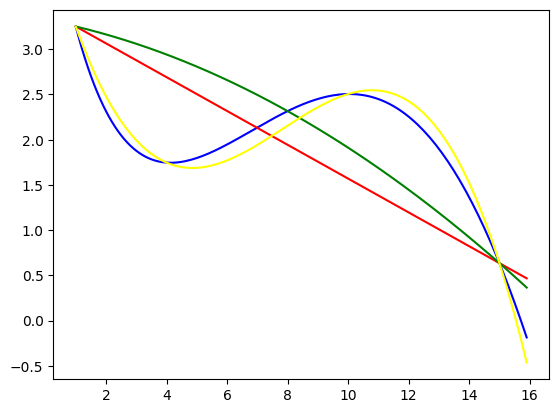

In [65]:
plt.plot(x, y, color='blue')
plt.plot(x, y_approx_1, color='red')
plt.plot(x, y_approx_2, color='green')
plt.plot(x, y_approx_3, color='yellow')

## Первая линейная аппроксимация плохо приближает данную функцию. Квадратная аппроксимация практически не улучшает приближение, относительно прошлой аппроксимации. Кубическая аппроксимация справилась с задачей куда лучше и качественней, учитывая выпуклости функции. 